In [43]:
__author__ = 'Anastasia Tsvetkova'
__email__  = 'tsvetkova.lea@gmail.com'

import yaml, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from avalanche import LC, Restored_LC

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
%config InlineBackend.figure_format='retina' # very useful command for high-res images

SEED=42
np.random.seed(SEED)

In [45]:
# set the username for the path of the files:
user='LB'
#user='AF'

if user=='LB':
    file_path='/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
elif user=='AF':
    file_path='E:/grb_to_test/CGRO_BATSE/'
else:
    raise ValueError('Assign to the variable "user" a correct username!')

N.B.: 
- We have to redefine the LC object every time we generate a light curve, otherwise the background will accumulate, and dominate over the "true" simulated GRB signal.
- ask Anastasia why she generates two times the lc (i.e., `LC._plot_lc`), and why it's different in the two cases;

The 7 parameters to be optimezed are:
- `mu`
- `mu0`
- `alpha`
- `delta1`
- `delta2`
- `tau_min`
- `tau_max`

In [44]:
# The values of the 7 parameters from the paper [Stern & Svensson, 1996] are
mu=1.2
mu0=1
alpha=4
delta1=-0.5
delta2=0
tau_min=0.02
tau_max=26

# other parameters
with_bg=False # generate lc with the background added
res=0.064     # time resolution of the light curves [ms]
n_cut=2000    # maximum number of pulses in avalanche (useful to speed up the 
              # simulations but in odds with the "classic" approach). CHECK THAT
              # THE FINAL RESULT IS NOT INFLUENCED BY THIS CUT! 

### Let's generate several light curves

In [3]:
# test execution time

test_execution_time=False

if test_execution_time:
    lc = LC(mu=mu,
            mu0=mu0,
            alpha=alpha,
            delta1=delta1,
            delta2=delta2,
            tau_min=tau_min, 
            tau_max=tau_max,
            res=res,
            n_cut=n_cut) 

    %timeit lc.generate_avalanche(seed=None) # ~4 ms per lc

Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 2009
---
Total number of pulses                : 2010
--------------------------------------------------------------------------


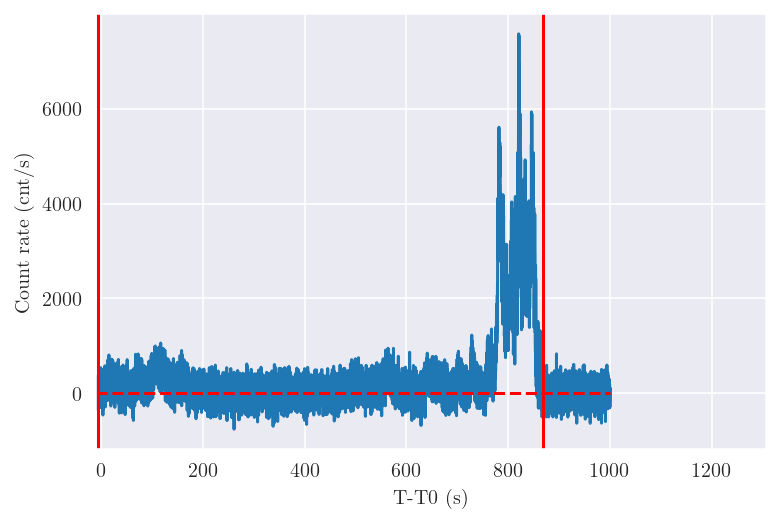

Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 1
---
Total number of pulses                : 2
--------------------------------------------------------------------------


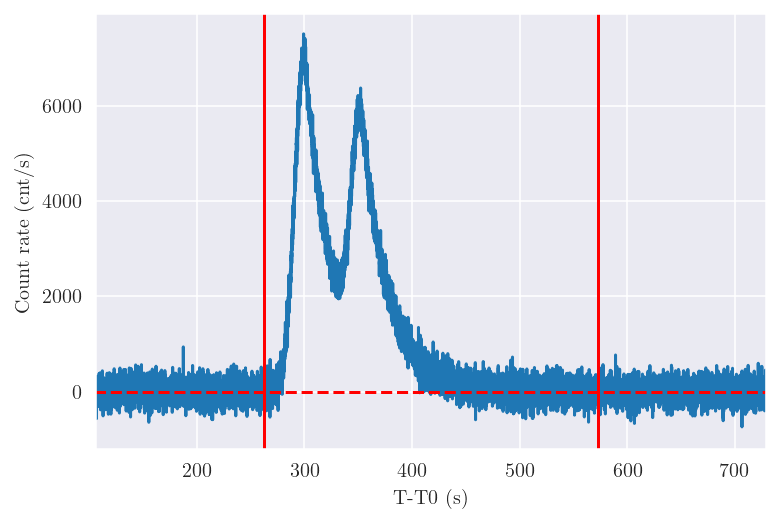

Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 2
---
Total number of pulses                : 3
--------------------------------------------------------------------------


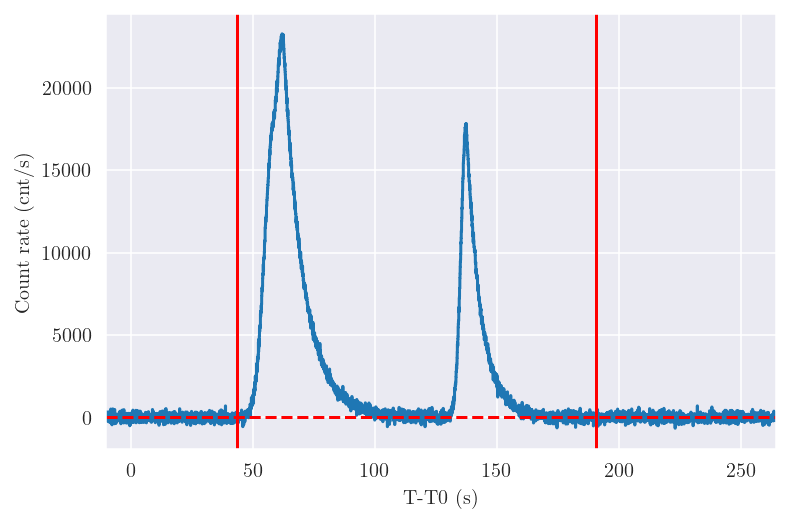

Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1
--------------------------------------------------------------------------


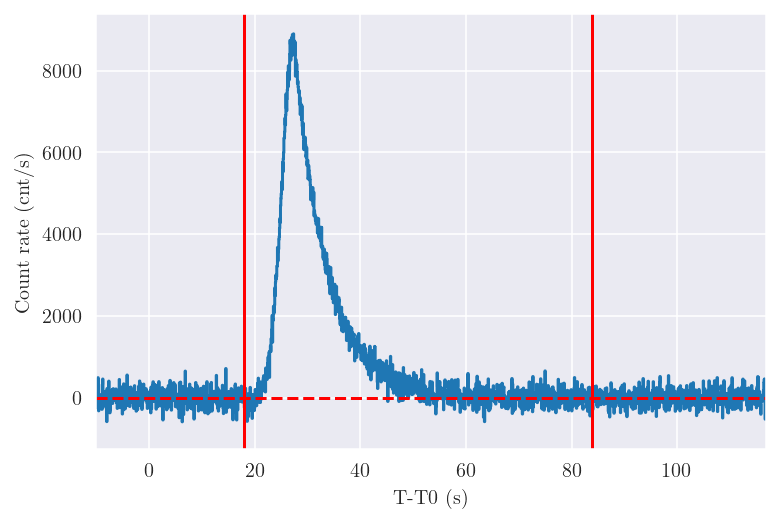

In [4]:
N_img=4
for i in range(N_img):
    lc = LC(mu=mu,
            mu0=mu0,
            alpha=alpha,
            delta1=delta1,
            delta2=delta2,
            tau_min=tau_min,
            tau_max=tau_max,
            res=res,
            n_cut=n_cut,
            with_bg=with_bg)
    lc.generate_avalanche(seed=None)
    # print( len(lc._plot_lc) )
    lc.plot_lc(save=False,
               show_duration=True,
               rescale=True)
    del(lc)

The quantity `LC._plot_lc` contains the final light curve

Number of spontaneous (primary) pulses: 5
Total number of child pulses          : 77
---
Total number of pulses                : 82
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 5
Total number of child pulses          : 77
---
Total number of pulses                : 82
--------------------------------------------------------------------------


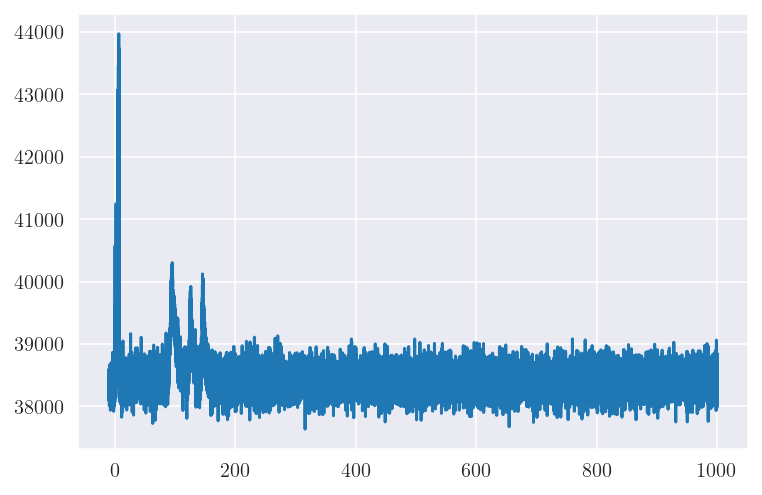

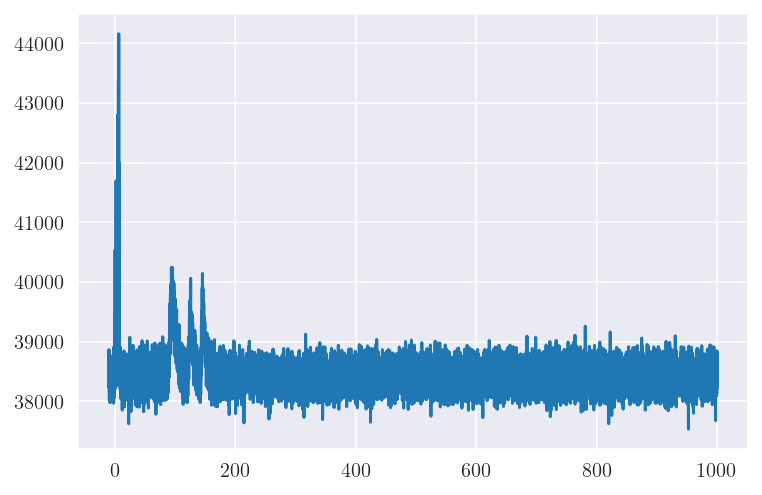

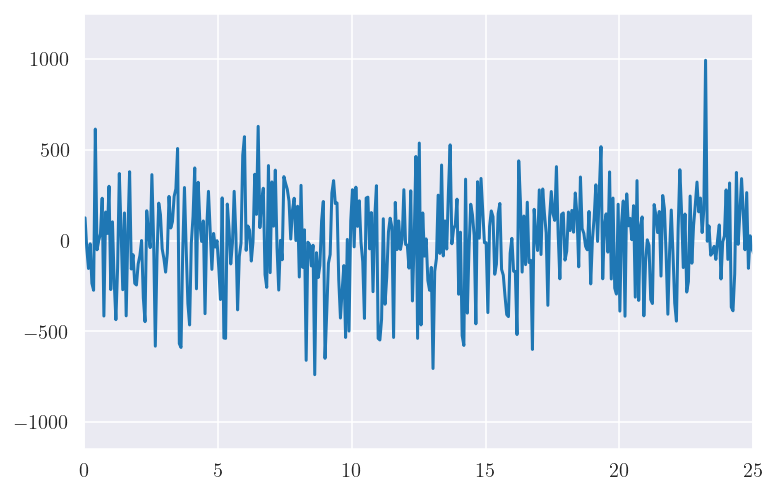

In [7]:
n_cut_1=10000
n_cut_2=100

lc1 = LC(mu=mu,
         mu0=mu0,
         alpha=alpha,
         delta1=delta1,
         delta2=delta2,
         tau_min=tau_min, 
         tau_max=tau_max,
         res=res,
         n_cut=n_cut_1)
lc2 = LC(mu=mu,
         mu0=mu0,
         alpha=alpha,
         delta1=delta1,
         delta2=delta2,
         tau_min=tau_min, 
         tau_max=tau_max,
         res=res,
         n_cut=n_cut_2)
            
par_1 = lc1.generate_avalanche(seed=SEED+3)
par_2 = lc2.generate_avalanche(seed=SEED+3)

plt.plot(lc1._times, lc1._plot_lc)
plt.show()

plt.plot(lc2._times, lc2._plot_lc)
plt.show()

plt.plot(lc1._times, lc1._plot_lc-lc2._plot_lc) 
# maybe the difference is not zero due to poissonian background;
# try to fix the seed also there and see if it disappears... 
plt.xlim(0, 25)
plt.show()

In [10]:
print(lc1._ampl)

0.5021942016886071


## Test 1: Duration (T90) distribution 

### T90 definition
The 90% duration of the burst in seconds. T90 measures the duration of the time interval during which 90% of the total observed counts have been detected. The start of the T90 interval is defined by the time at which 5% of the total counts have been detected, and the end of the T90 interval is defined by the time at which 95% of the total counts have been detected. (definition from: https://heasarc.gsfc.nasa.gov/grbcat/notes.html)


NB: For BATSE, all the T90s of the GRBs have been already evaluated by Cristiano.

## Test 2: Average Peak-Aligned Profiles

Following the technique described in Mitranof et al., 1996 (https://ui.adsabs.harvard.edu/abs/1996MmSAI..67..417M/abstract) and working on the time interval from 0 to 150 s from the peak (as done in Stern+1996)

In [11]:
# We pad the lc both to the left and to the right with zeros (of a number equal
# to the length of the lc itself), so there is available space for shifting the
# values on both sides, since we have to align the peaks 
a = np.array([1,2,99,1])
b = np.pad(a, (len(a),len(a)), 'constant', constant_values=(0))
print(a)
print(b)
print(np.argmax(a))

# I want the max of the lc to be exactly at the position len(a):
c = np.roll(b,-np.argmax(a))
assert np.argmax(c)==len(a)

[ 1  2 99  1]
[ 0  0  0  0  1  2 99  1  0  0  0  0]
2


In [12]:
def pad_and_align(LC):
    # we pad the lc both to the left and to the right with zeros (of a number
    # equal to the length of the lc itself), so there is available space for 
    # shifting the values on both sides, since we have to align the peaks    
    lc        = LC._plot_lc
    padded_lc = np.pad(lc, (len(lc),len(lc)), 'constant', constant_values=(0))
    #print(np.argmax(padded_lc))

    # we want the max of the lc to be exactly at the position len(lc)
    aligned_lc = np.roll(padded_lc,-np.argmax(lc))
    assert np.argmax(aligned_lc)==len(lc), "the peak is not aligned correctly..."

    LC._plot_lc_pad_aligned = aligned_lc

Actually, we only need the 'discharge' curve, and not the rise part, so what we can do is trivially shift on the first position of the array the maximum value of the light curve.

In [13]:
lc = np.array([1,2,99,1,2,3])

# first, we truncate the array, keeping only the part after the maximum
print(np.max(lc))
print(np.argmax(lc))
truncated_lc = lc[np.argmax(lc):]
print(truncated_lc)

# then we renormalize w.r.t. the value of the lc at his maximum
truncated_lc = truncated_lc/np.max(truncated_lc)
print(truncated_lc)
# assert truncated_lc[0]==1, "the peak is not aligned correctly..."
assert np.isclose(truncated_lc[0], 1, atol=1e-08), "the peak is not aligned correctly..."

# we then pad the lc to the right with zeros, so that to reach the initial size 
# of lc itself
# we pad with ones insted of zeros, since then we have to compute the log
padded_lc = np.pad(truncated_lc, (0,len(lc)-len(truncated_lc)), 'constant', constant_values=(1))
print(padded_lc)
assert len(lc)==len(padded_lc)

99
2
[99  1  2  3]
[1.         0.01010101 0.02020202 0.03030303]
[1.         0.01010101 0.02020202 0.03030303 1.         1.        ]


In [14]:
def align_lc(LC):

    lc = LC._plot_lc
    # print(np.max(lc))
    # print(np.argmax(lc))
    # First, we truncate the array, keeping only the part after the maximum
    truncated_lc = lc[np.argmax(lc):]
    # print(truncated_lc)
    
    # Then we renormalize w.r.t. the value of the lc at his maximum
    truncated_lc = truncated_lc / np.max(truncated_lc)
    # print(truncated_lc)
    # assert truncated_lc[0]==1, "the peak is not aligned correctly..."
    assert np.isclose(truncated_lc[0], 1, atol=1e-08), "the peak is not aligned correctly..."
    
    # We then pad the lc to the right so that to reach the initial size of the
    # lc itself. We pad with ones instead of zeros, since then we have to 
    # compute the log
    padded_lc = np.pad(truncated_lc, (0,len(lc)-len(truncated_lc)), 'constant', constant_values=(1))
    assert len(lc)==len(padded_lc), "the padding procedure is not correct..."
    
    LC._plot_lc_max_aligned = padded_lc

Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1
--------------------------------------------------------------------------


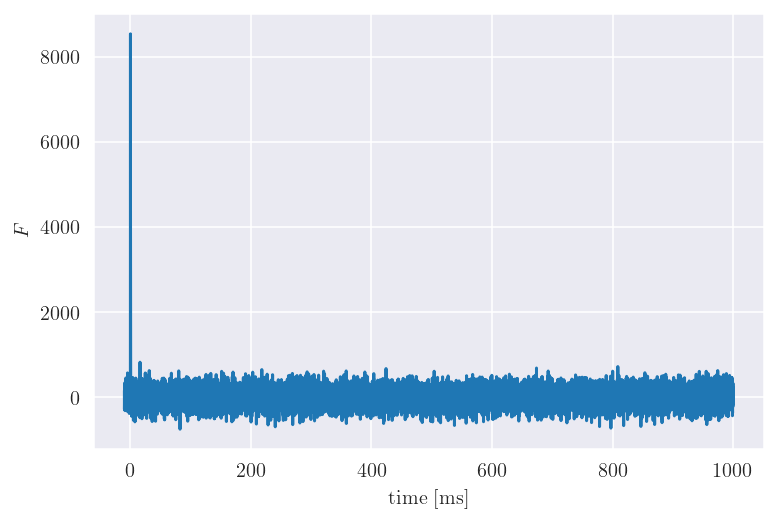

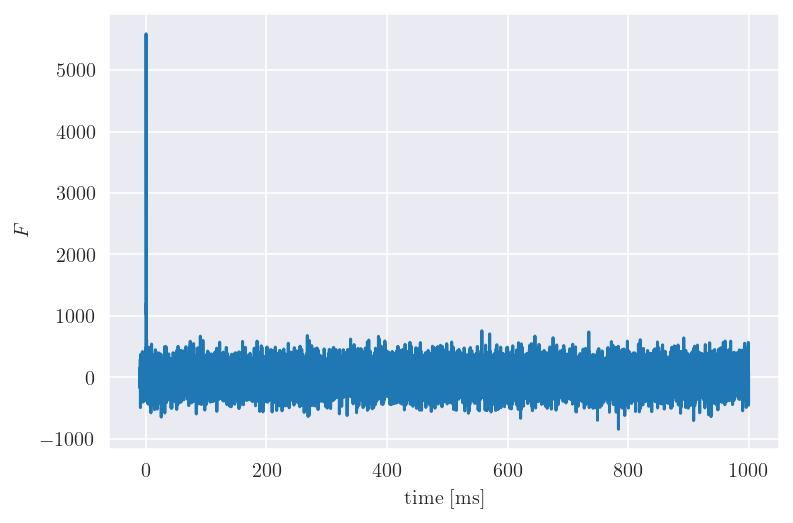

/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log10
/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log10


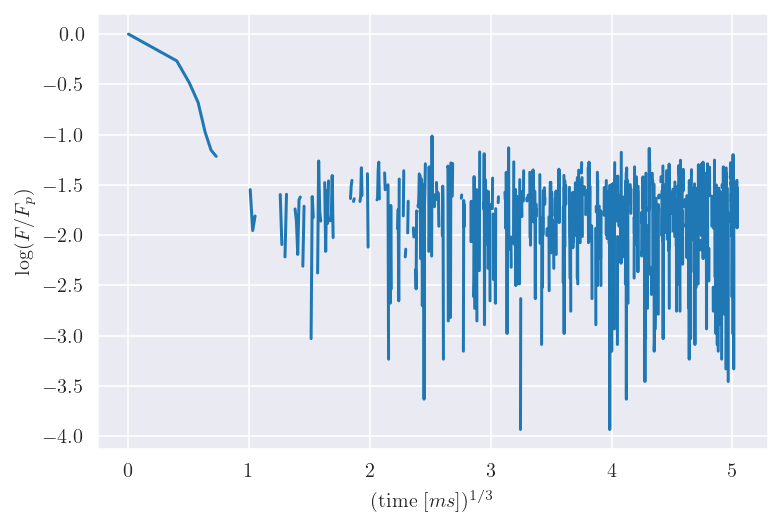

/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log10
/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in log10


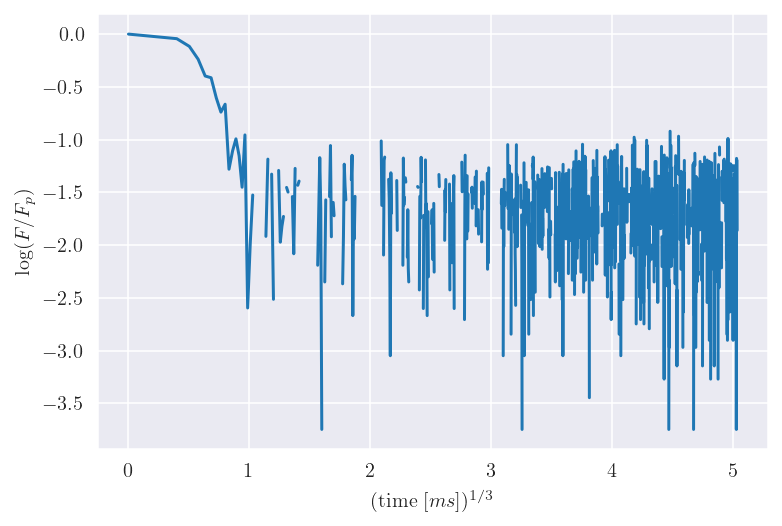

In [15]:
try:
    del(lcA)
    del(lcB)
except:
    pass

with_bg=False

lcA = LC(mu=mu,
         mu0=mu0,
         alpha=alpha,
         delta1=delta1,
         delta2=delta2,
         tau_min=tau_min, 
         tau_max=tau_max,
         res=res,
         n_cut=n_cut,
         with_bg=with_bg) 
lcB = LC(mu=mu,
         mu0=mu0,
         alpha=alpha,
         delta1=delta1,
         delta2=delta2,
         tau_min=tau_min, 
         tau_max=tau_max,
         res=res,
         n_cut=n_cut,
         with_bg=with_bg) 
lcA.generate_avalanche(seed=None)
lcB.generate_avalanche(seed=None)

################################################################################

plt.plot(lcA._times, lcA._plot_lc)
plt.xlabel('time [ms]')
plt.ylabel(r'$F$')
plt.show()

plt.plot(lcB._times, lcB._plot_lc)
plt.xlabel('time [ms]')
plt.ylabel(r'$F$')
plt.show()

################################################################################

# pad_and_align(lcA)
# pad_and_align(lcB)
# 
# plt.plot(lcA._plot_lc_pad_aligned)
# plt.show()
# 
# plt.plot(lcB._plot_lc_pad_aligned)
# plt.show()

################################################################################

n_step=2000

align_lc(lcA)
align_lc(lcB)

times=np.arange(len(lcA._plot_lc_max_aligned)) * lcA._res

plt.plot((times[:n_step])**(1./3.), np.log10(lcA._plot_lc_max_aligned)[:n_step])
plt.xlabel(r'$(\mathrm{time}\ [ms])^{1/3}$')
plt.ylabel(r'$\log(F/F_p)$')
plt.show()

plt.plot((times[:n_step])**(1./3.), np.log10(lcB._plot_lc_max_aligned)[:n_step])
plt.xlabel(r'$(\mathrm{time}\ [ms])^{1/3}$')
plt.ylabel(r'$\log(F/F_p)$')
plt.show()

In [16]:
len(lcB._plot_lc_max_aligned)

15783

Now we just have to average a large number of curves (before taking the log), in order to obtain $\log(\langle F/F_p \rangle)$, and compare it to the same value of _real_ RGB ligth curves.

In [19]:
sum_lc=np.zeros(15783)
sum_lc2=np.zeros_like(sum_lc)
sum_lc3=np.zeros_like(sum_lc)
sum_acf=np.zeros_like(sum_lc)

with_bg=False

N_grb=5000
for i in range(N_grb):
    lc = LC(mu=mu,
            mu0=mu0,
            alpha=alpha,
            delta1=delta1,
            delta2=delta2,
            tau_min=tau_min, 
            tau_max=tau_max,
            res=res,
            n_cut=n_cut,
            with_bg=with_bg) 
    lc.generate_avalanche(seed=None)
    align_lc(lc)
    sum_lc+=lc._plot_lc_max_aligned
    sum_lc2+=(lc._plot_lc_max_aligned)**2
    sum_lc3+=(lc._plot_lc_max_aligned)**3
    #acf=np.correlate(lc._plot_lc[:n_step], lc._plot_lc[:n_step], mode='valid')
    #sum_acf+=acf/np.sum(lc._plot_lc**2)
    del(lc)

F_avg  = sum_lc /N_grb
F_avg2 = sum_lc2/N_grb
F_avg3 = sum_lc3/N_grb
F_rms  = ( F_avg2 - F_avg**2 )**(1./2.)
#acf_avf=sum_acf/N_grb
times  = np.arange(len(F_avg)) * res

Number of spontaneous (primary) pulses: 4
Total number of child pulses          : 139
---
Total number of pulses                : 143
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 3
Total number of child pulses          : 9
---
Total number of pulses                : 12
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 115
---
Total number of pulses                : 116
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 2
---
Total number of pulses                : 3
-----------------------------------------

In [21]:
# Export file with these columns: 
#   times, F_avg, F_rms, F_avg3
# where the average of the fluxes is renormalized to 1

outfile  = 'simulations.txt'
savefile = open(outfile, 'w')
for i in range(len(F_avg)):
    savefile.write('{0} {1} {2} {3}\n'.format(times[i], F_avg[i], F_rms[i], F_avg3[i]))

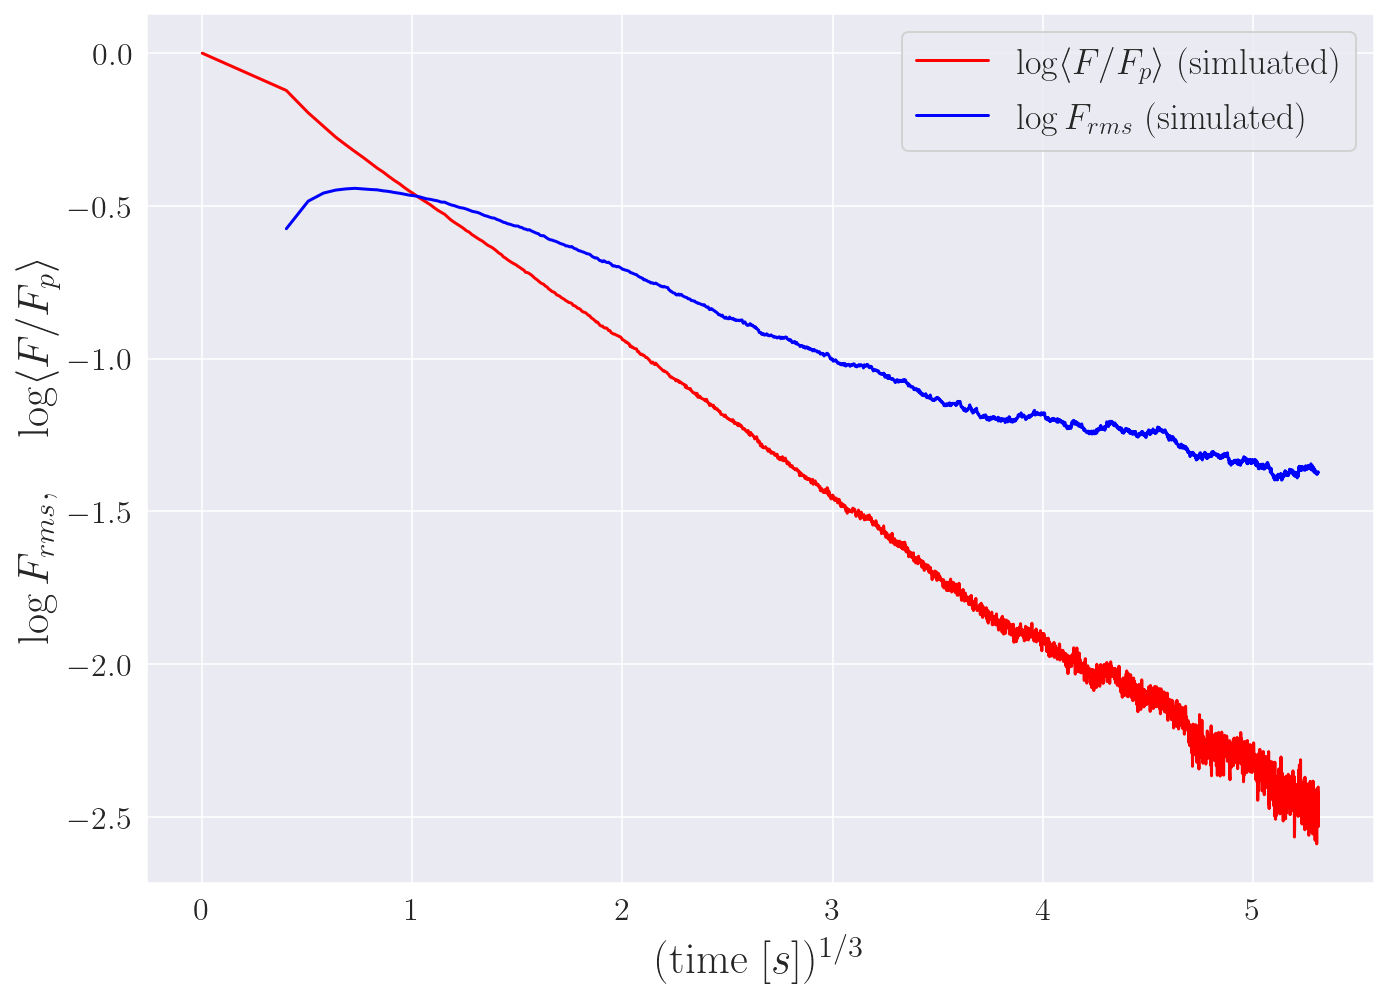

In [28]:
t_i=0   # [s]
t_f=150 # [s]
n_step=int((t_f-t_i)/res)

plt.figure(figsize=(11,8))
plt.plot((times[:n_step])**(1./3.),  np.log10(F_avg[:n_step]),  c='r', label=r'$\log\langle F/F_p\rangle$ (simluated)')
plt.plot((times[1:n_step])**(1./3.), np.log10(F_rms[1:n_step]), c='b', label=r'$\log F_{rms}$ (simulated)') # we have to remove the first value in F_rms, since its log diverges
plt.xlabel(r'$(\mathrm{time}\ [s])^{1/3}$', size=22)
plt.ylabel(r'$\log F_{rms}$, \quad $\log \langle F/F_p\rangle$', size=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 18})
plt.show()

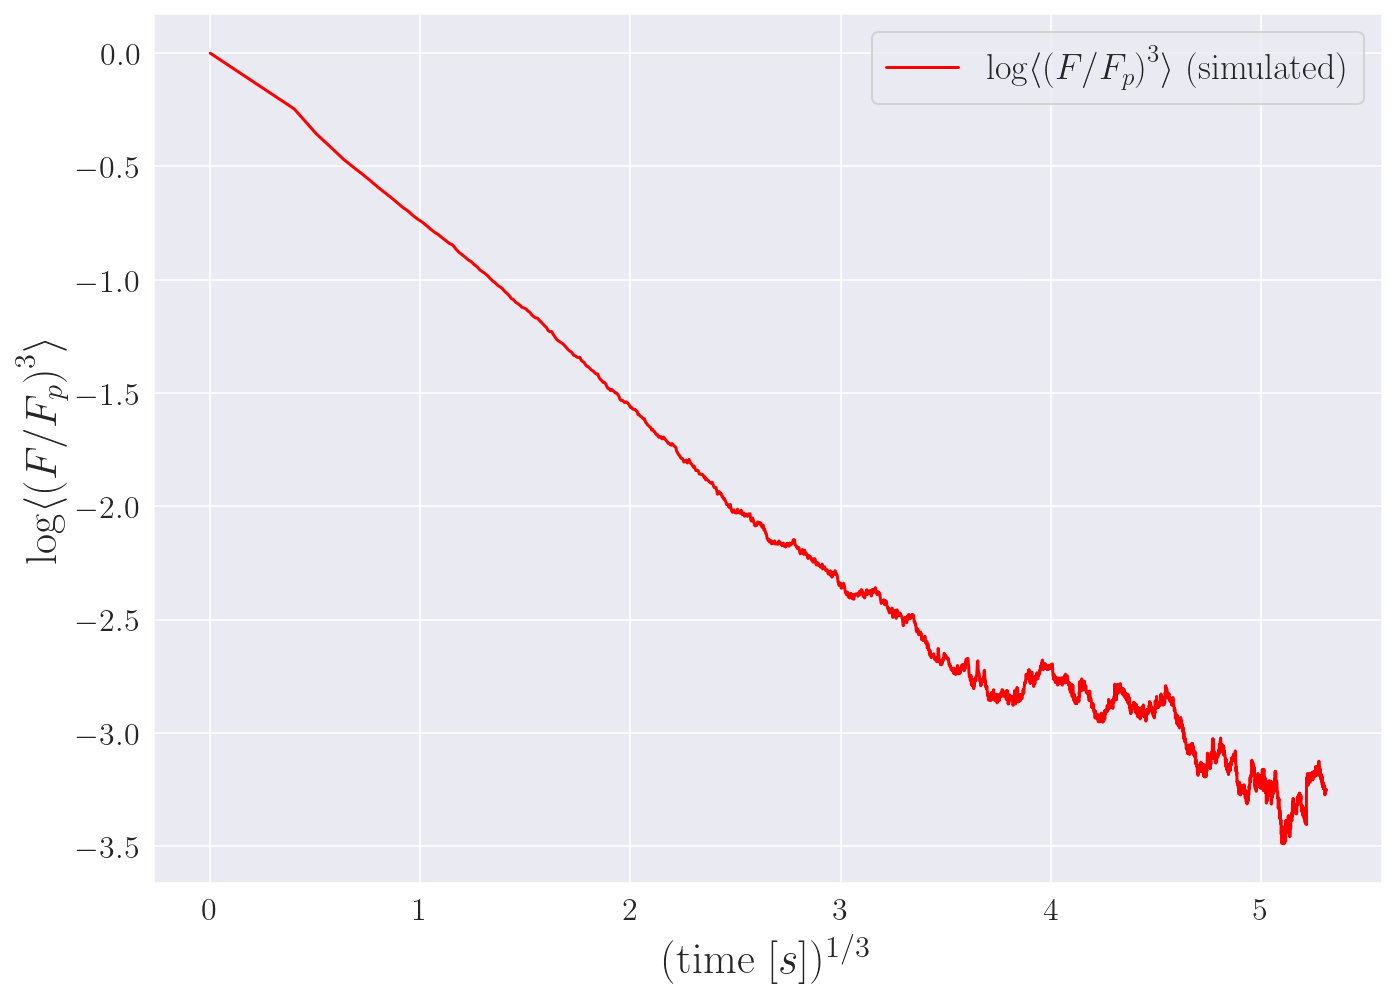

In [26]:
plt.figure(figsize=(11,8))
plt.plot((times[:n_step])**(1./3.),  np.log10(F_avg3[:n_step]),  c='r', label=r'$\log \langle {(F/F_p)}^3\rangle$ (simulated)')
# we have to remove the first value in F_rms, since its log diverges
plt.xlabel(r'$(\mathrm{time}\ [s])^{1/3}$', size=22)
plt.ylabel(r'$\log \langle {(F/F_p)}^3\rangle$', size=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 18})
plt.show()

## Test 3: Autocorrelation
Following the technique described in Link et al. 1993 (https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract):

For a time lag $\tau$, the autocorrelation function is defined as
$$
    A(\tau)=\frac{\langle[s(t+\tau)-b][s(t)-b]\rangle_t}{\left\langle[s(t)-b]^2\right\rangle_t}
$$
where $s(t)$ is the intrinsic count rate due to the source (independent of photon counting statistics), $b$ is the background count rate, and \langle\rangle$_t$ denotes a time-average over the data interval. The measured count rate is $m(t)=s(t)+e(t)$, where $e(t)$ is the error. For a sufficiently long data set, the time average of $e$ vanishes; i.e., $\langle e(t)\rangle_t=0$. Assuming that the signal

In [50]:
t_i=0          # [s]
t_f=150        # [s]
bin_time=0.064 # [s]

# small sample of GRBs:
grb_list  = ["00105_all_bs.out"]
#grb_list  = ["00105_all_bs.out","00107_all_bs.out","00108_all_bs.out","00109_all_bs.out","00110_all_bs.out"]

# full sample of GRBs:
# grb_list = [grb_num.rstrip('\n') + '_all_bs.out' for grb_num         \
#             in open(file_path + 'alltrig_long.list').readlines()] +  \
#             [grb_num.rstrip('\n') + '_all_bs.out' for grb_num        \
#             in open(file_path + 'alltrig_short.list').readlines()]

n_steps = int((t_f-t_i)/bin_time)
steps   = np.arange(n_steps)
acf     = np.zeros_like(steps)

#for grb in grb_list:
for grb in grb_list:
    times, counts, errs = np.loadtxt(file_path+grb, unpack=True)
    acf = acf + [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in steps]
acf /= len(grb_list)

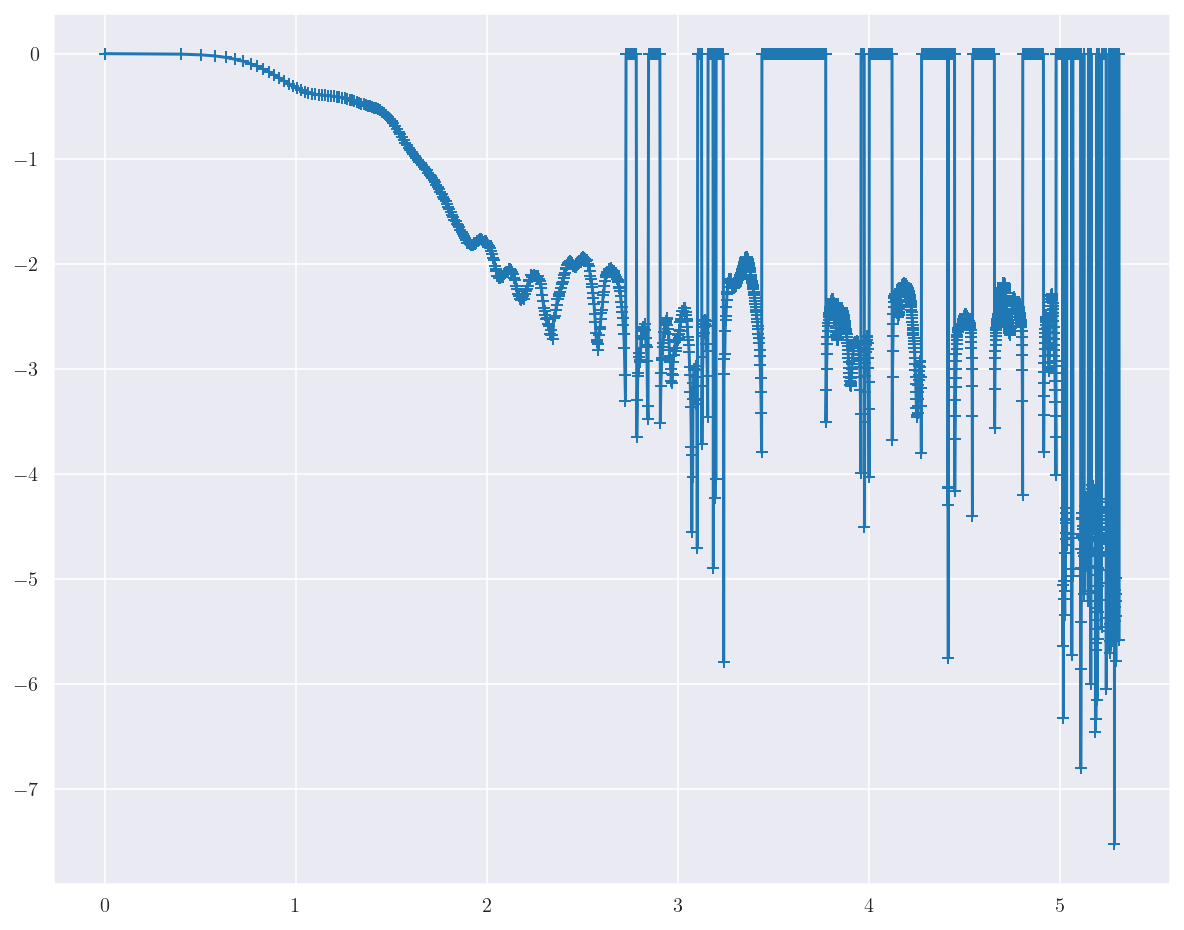

In [51]:
#Plot average acf
acf[acf <= 0] = 1
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
#ax.grid()
ax.plot((steps*bin_time)**(1/3), np.log10(acf), marker='+')
plt.show()

In [39]:
from astroML.time_series import generate_damped_RW
from astroML.time_series import ACF_scargle , ACF_EK

t  = np.arange(0, 1000)
y  = generate_damped_RW(t, tau=300)
dy = 0.1
y  = np.random.normal(y, dy)

# Scargle's method
ACF_S, bins_S = ACF_scargle(t, y, dy)

# Edelson-Krolik method
ACF_EK, ACF_EK_err, bins_EK = ACF_EK(t, y, dy)

        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]
        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]


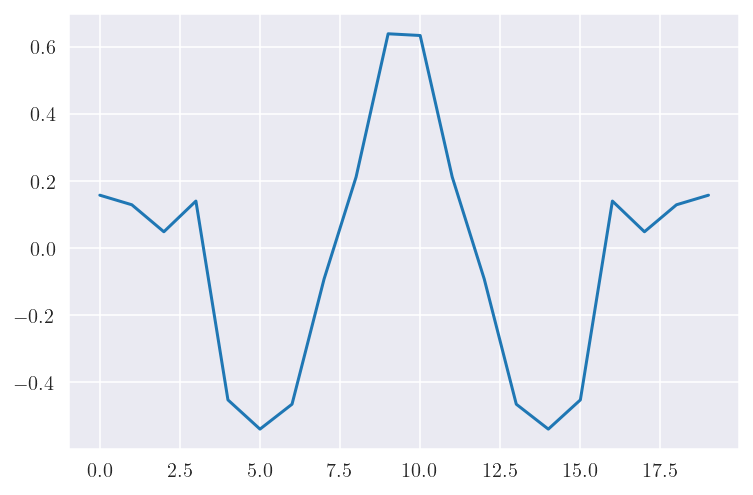

In [40]:
plt.plot(ACF_EK)

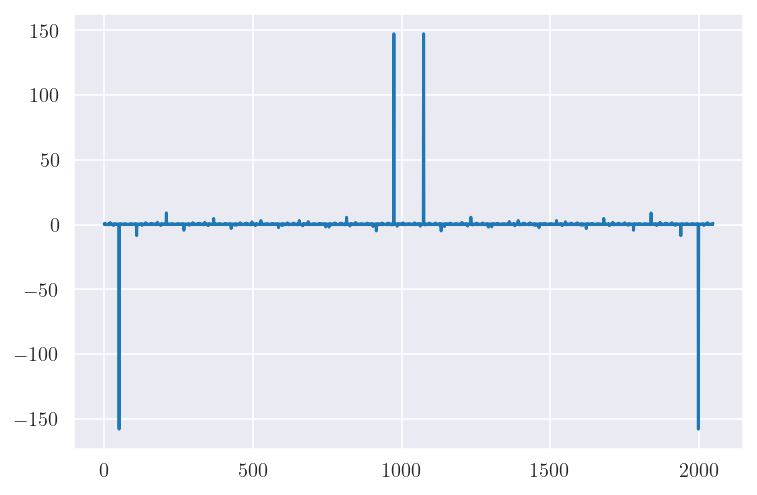

In [41]:
plt.plot(ACF_S)

In [55]:
import scipy.signal as sc

corr = sc.correlate(counts, counts)

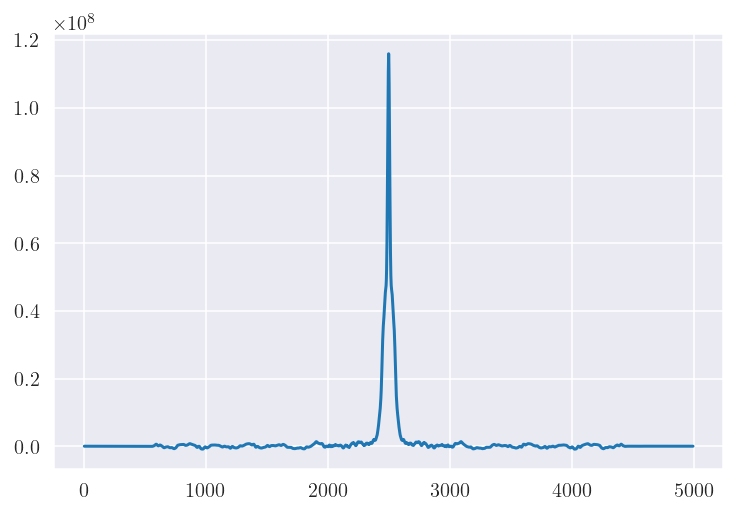

In [57]:
plt.plot(corr)

In [7]:
lc.hdf5_lc_generation(outfile="./test.h5", overwrite=True, seed=17)

In [10]:
filename = "./test.h5"

with h5py.File(filename, "r") as hf:
    data = np.array(hf.get('GRB_PARAMETERS/GRB_1')[:])
    hf['GRB_PARAMETERS/GRB_1'].attrs.keys()
    n_pulses  = hf['GRB_PARAMETERS/GRB_1'].attrs['N_PULSES']
    peak_flux = hf['GRB_PARAMETERS/GRB_1'].attrs['PEAK_VALUE']
    
data.shape

(12, 4)

### Let's open a yaml-file with avalanches and plot the T90 distribution for the sample

In [2]:
with open("./avalanche_parameters.yml", 'r') as f:
        loaded_data = yaml.safe_load(f)

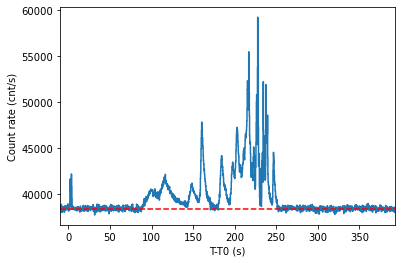

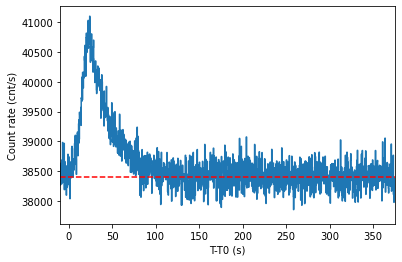

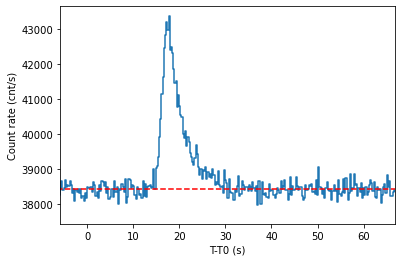

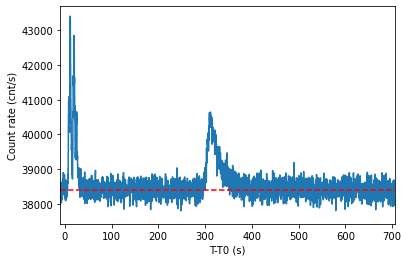

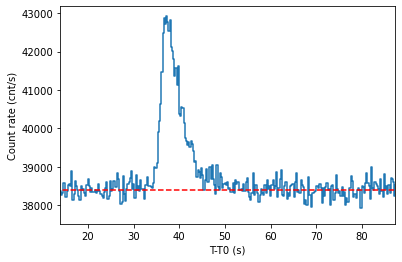

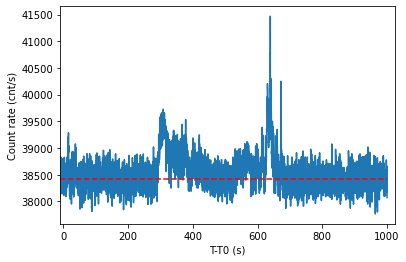

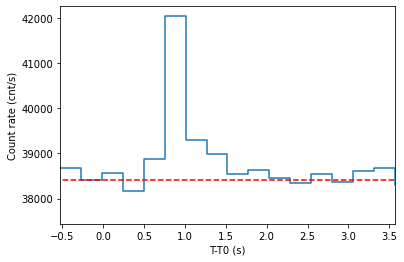

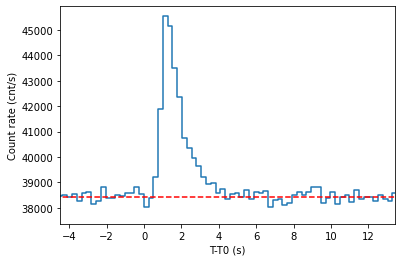

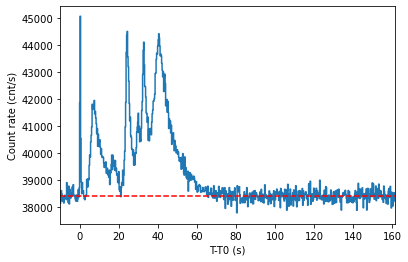

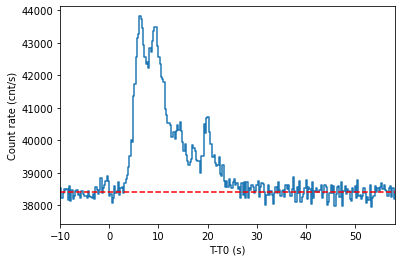

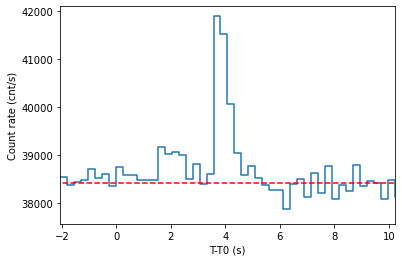

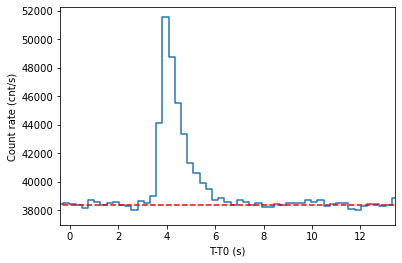

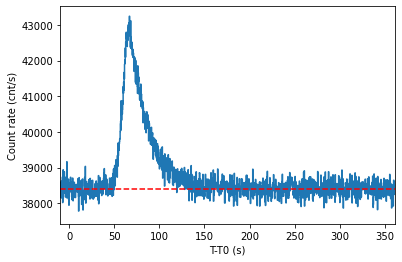

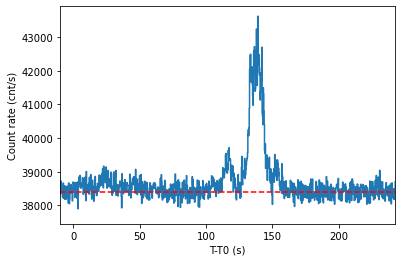

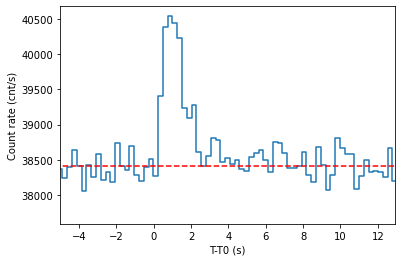

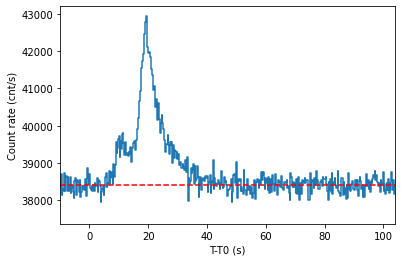

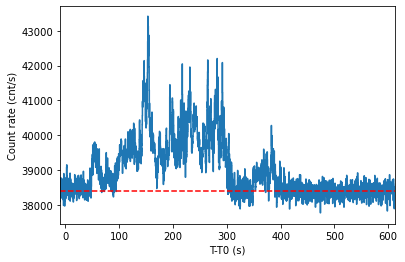

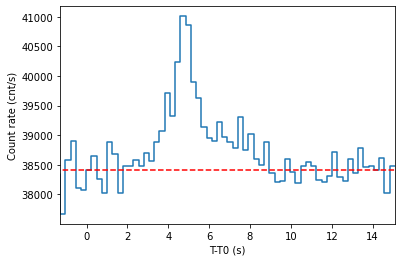

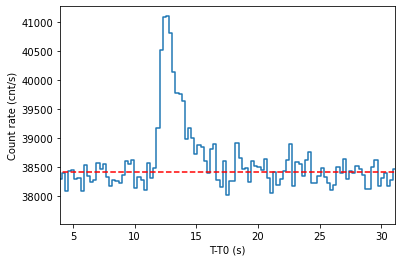

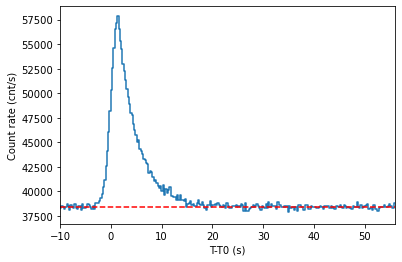

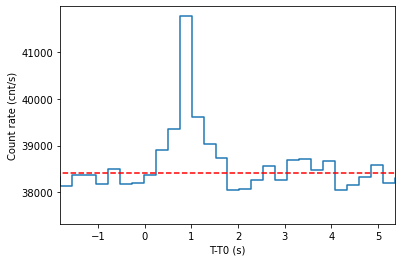

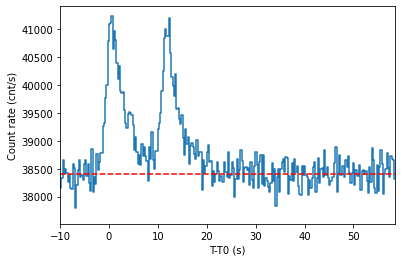

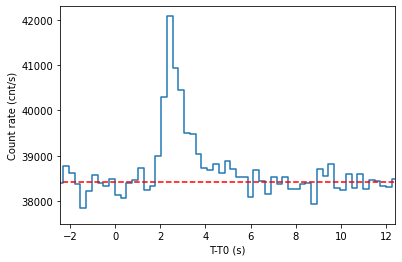

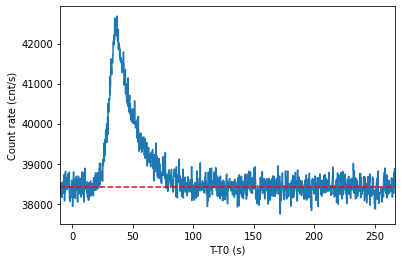

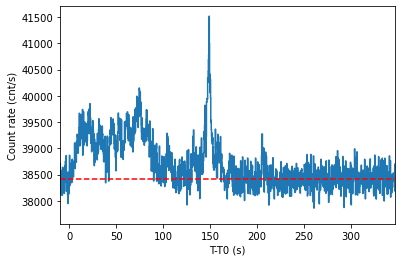

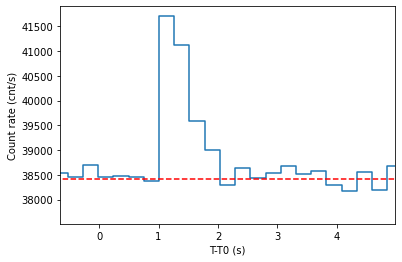

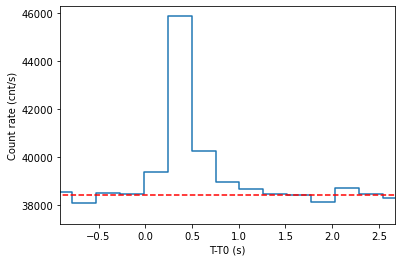

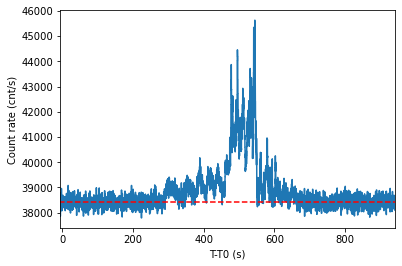

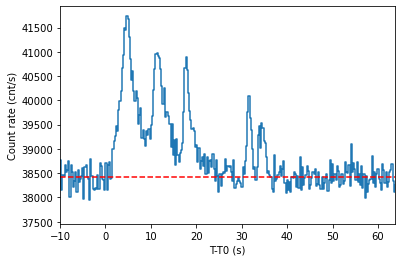

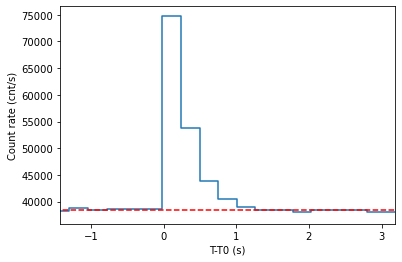

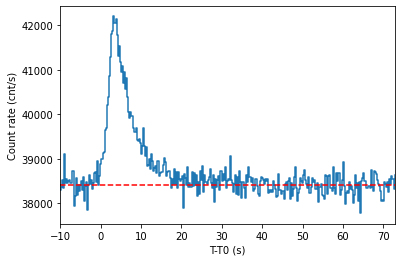

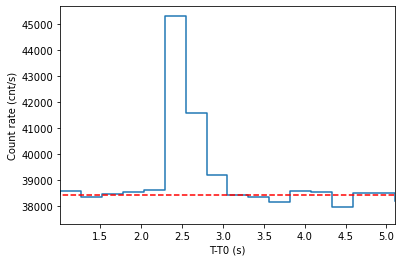

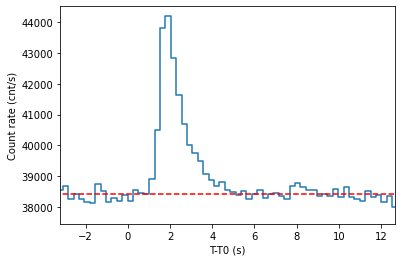

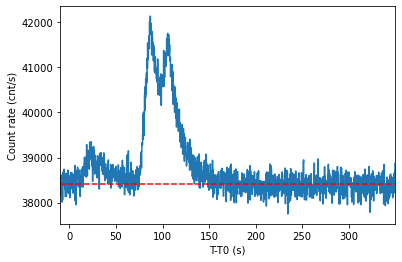

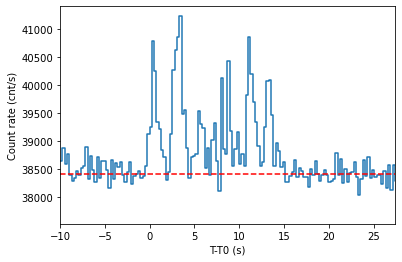

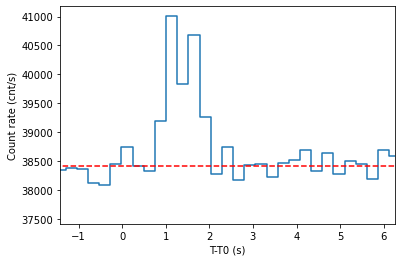

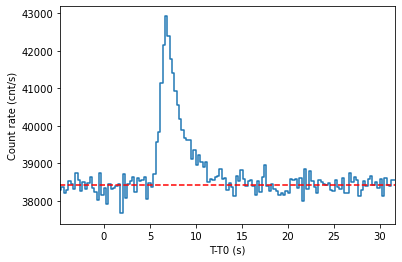

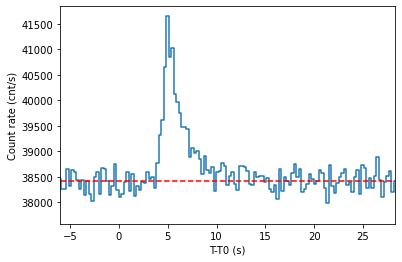

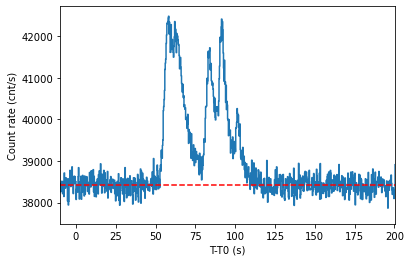

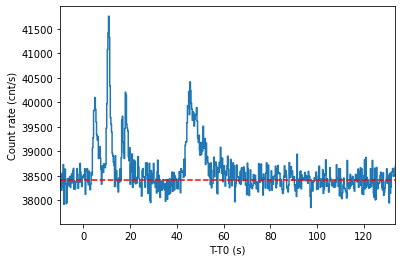

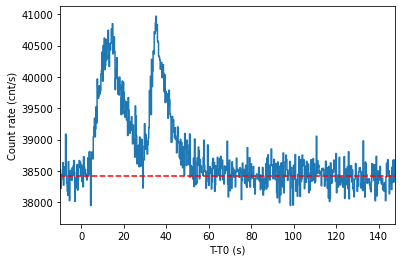

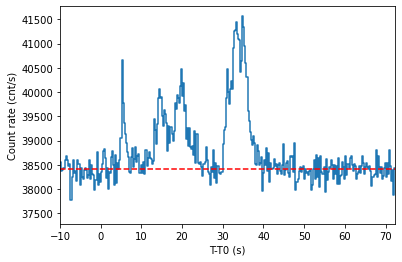

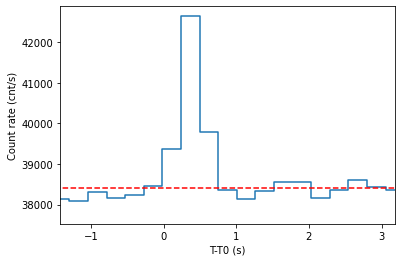

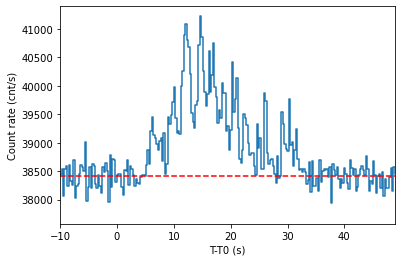

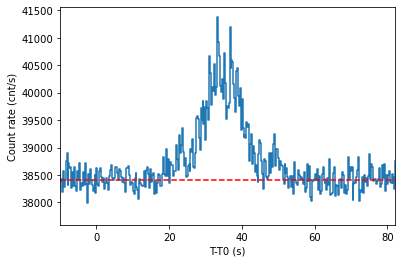

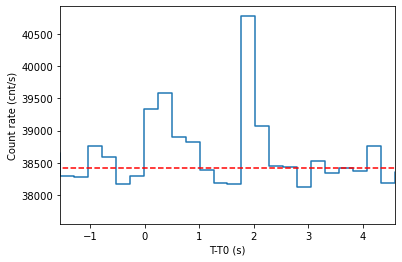

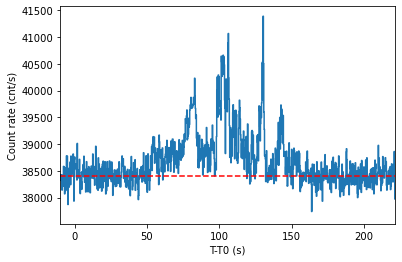

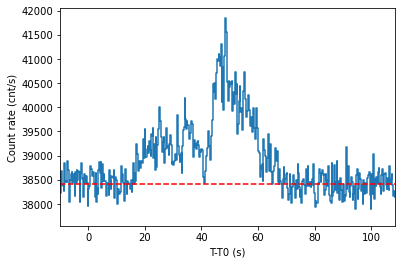

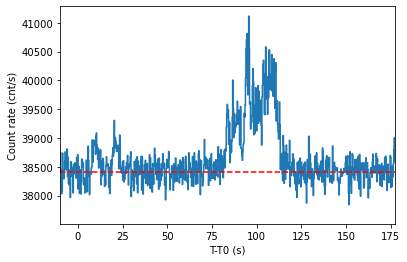

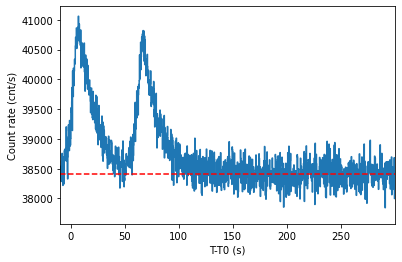

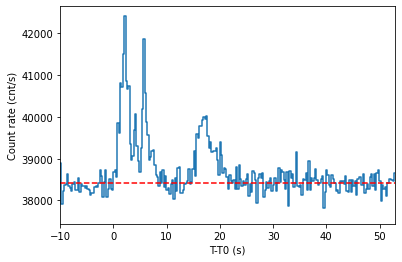

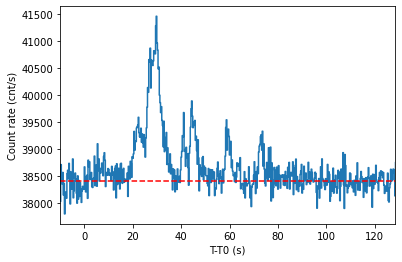

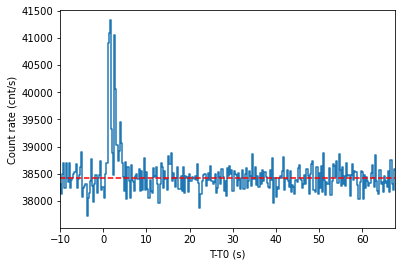

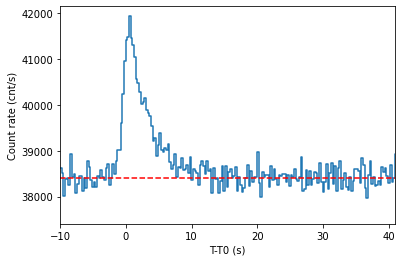

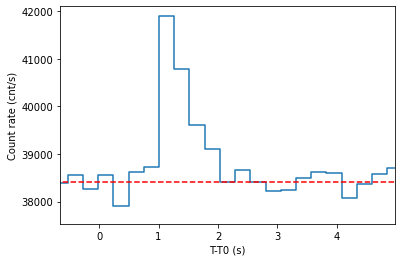

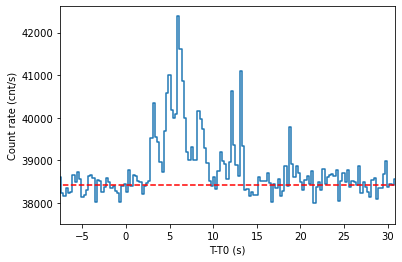

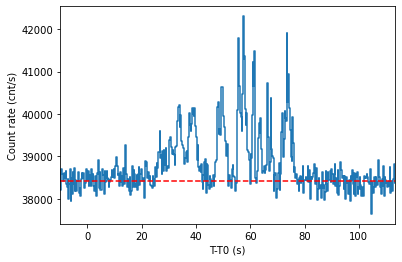

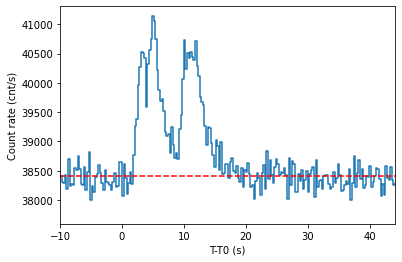

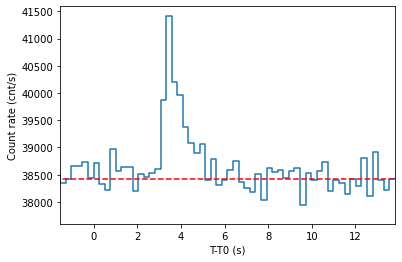

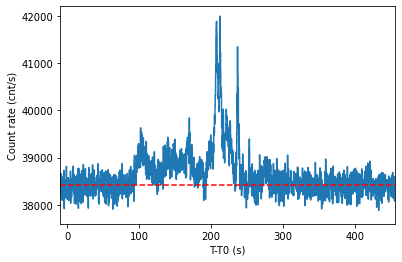

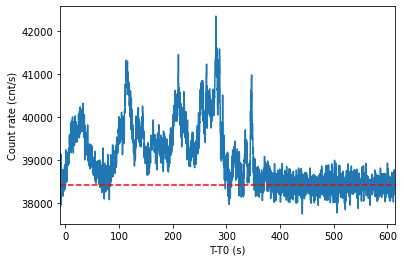

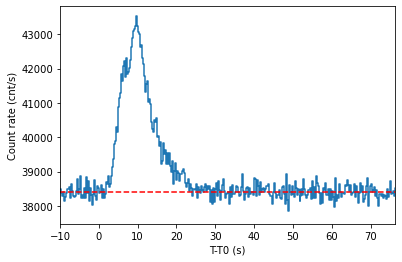

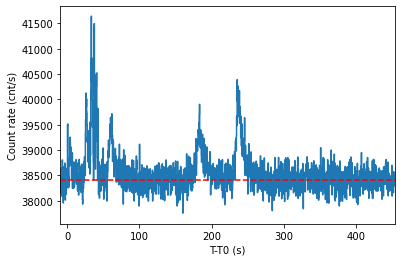

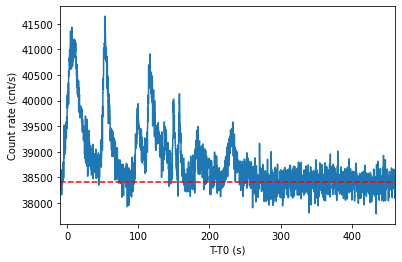

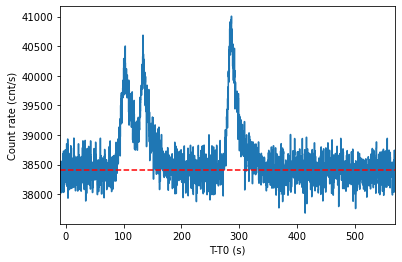

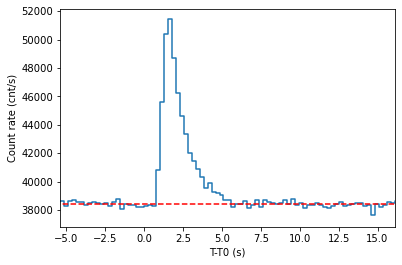

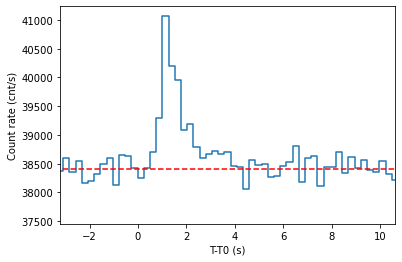

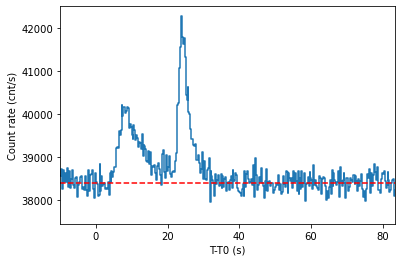

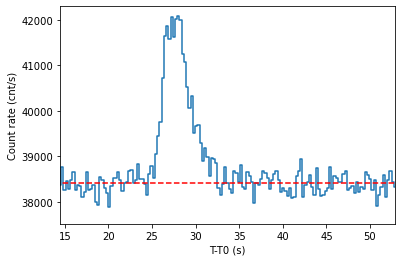

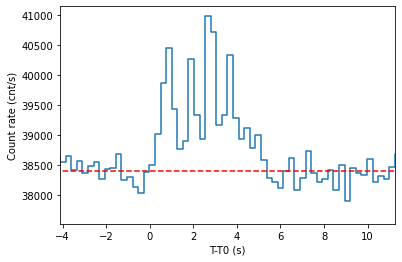

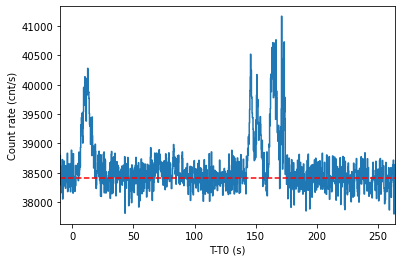

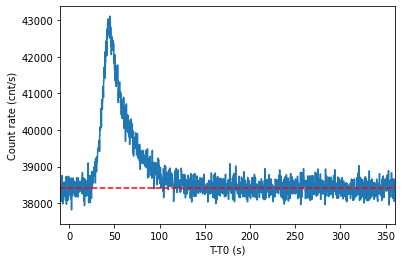

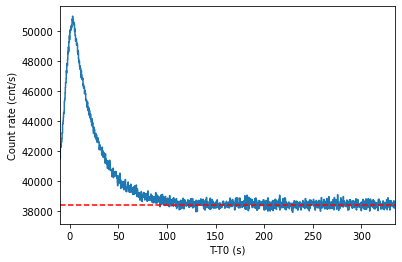

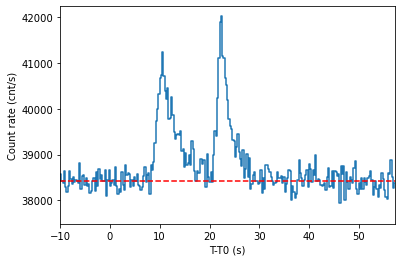

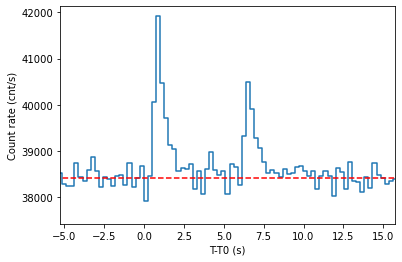

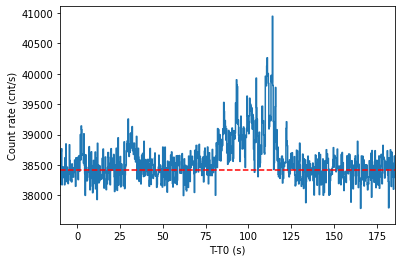

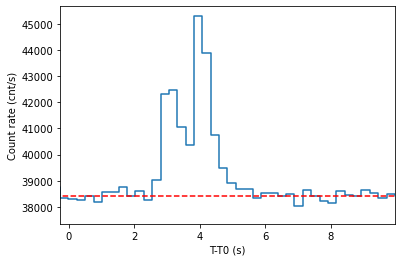

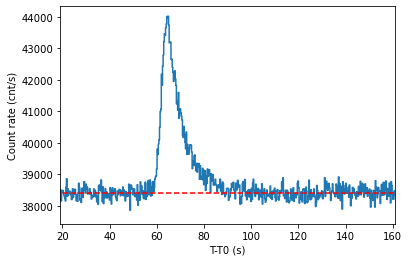

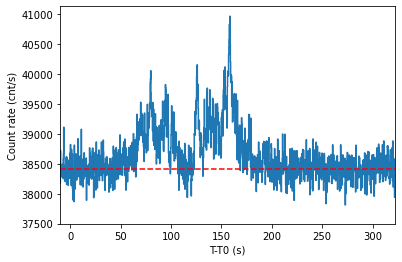

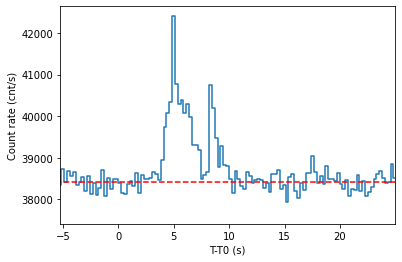

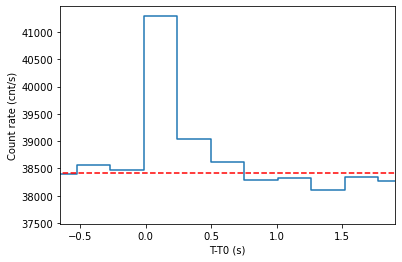

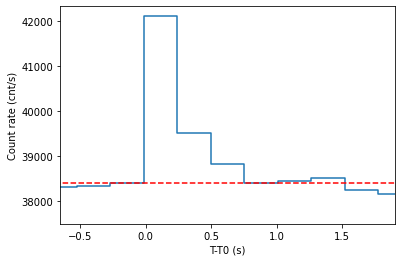

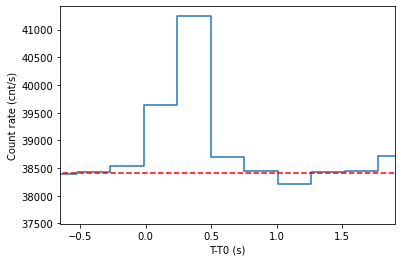

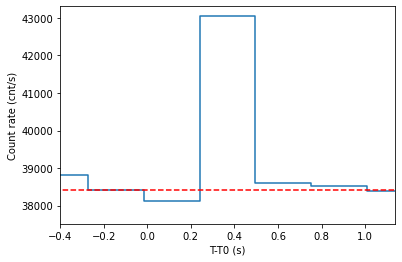

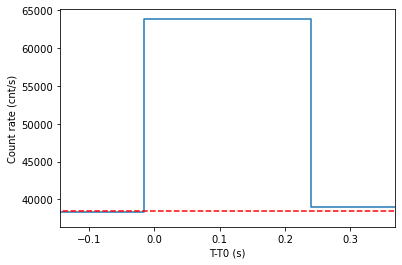

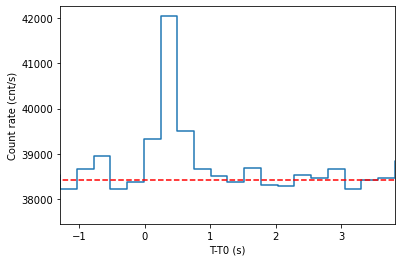

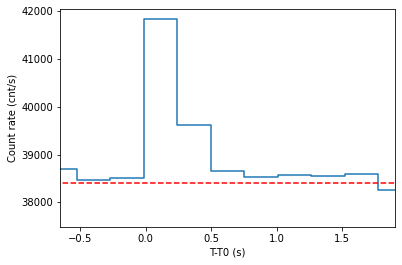

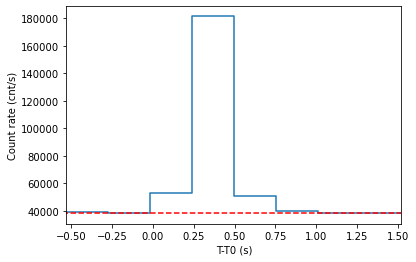

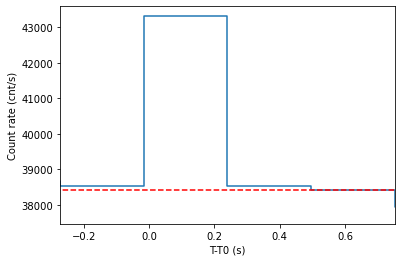

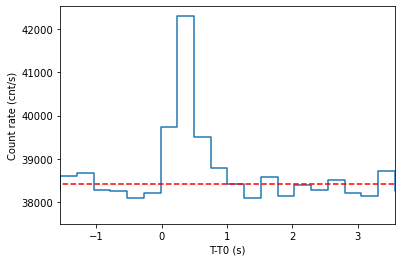

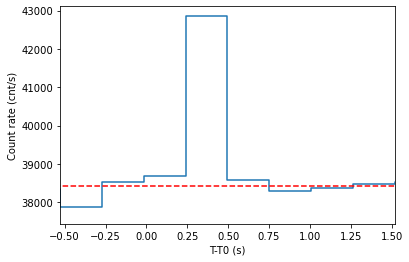

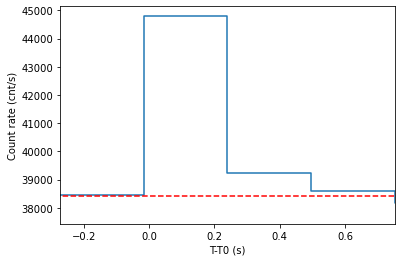

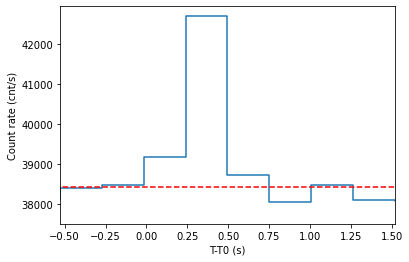

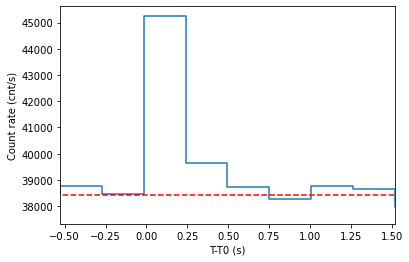

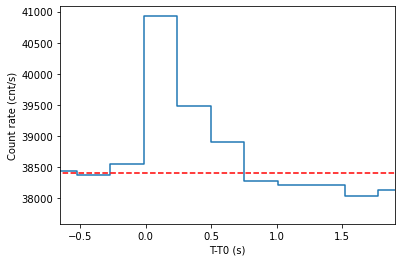

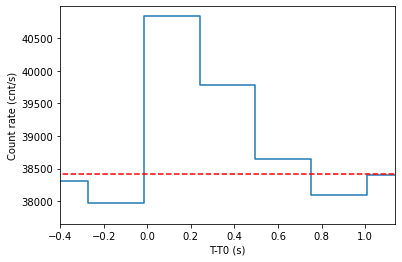

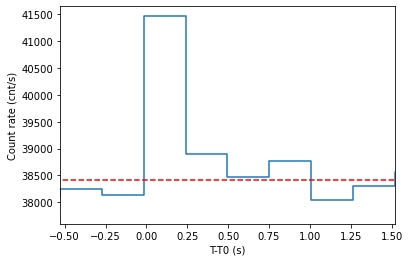

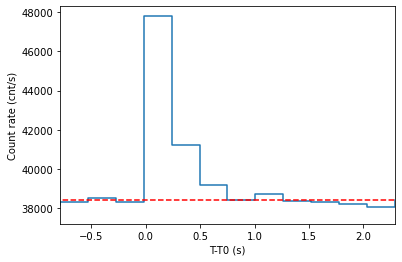

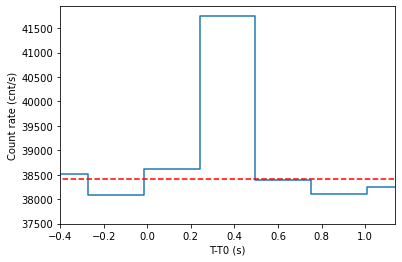

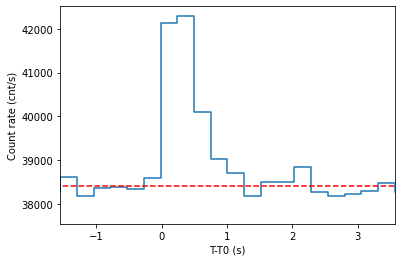

In [5]:
T90 = list()

for name in loaded_data:
    par_list = list(name.values())[0]
    lc = Restored_LC(par_list)
    lc._with_bg=True
    lc.plot_lc()
    T90.append(float(lc.T90[0]))

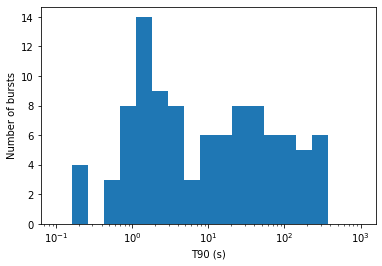

In [4]:
plt.hist(T90, bins=np.geomspace(0.1,1000,20))
plt.xlabel("T90 (s)")
plt.ylabel("Number of bursts")
plt.xscale('log')
plt.show()